In [50]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import entropy, pearsonr
from sklearn.preprocessing import scale 
import seaborn as sns
import yfinance as yf
import itertools
import time

In [31]:
def ordinalPattern(time_series, d):
    n = len(time_series)
    patterns = []
    for i in range(n - d + 1):
        sub_seq = time_series[i:i + d]
        ranks = np.argsort(np.argsort(sub_seq))
        patterns.append(tuple(ranks))
    return patterns

def ordinalPatternAll(d):
    perms = list(itertools.permutations(range(d)))
    return perms

def ordinalPatternAllIdx(d):
    all_patterns = ordinalPatternAll(d)
    all_patterns_idx = {}
    for i in range(len(all_patterns)):
        all_patterns_idx[i]=all_patterns[i]
    return all_patterns_idx

def timeSeriesPattern(time_series, d):
    patterns = ordinalPattern(time_series, d)
    all_patterns=ordinalPatternAllIdx(d)
    time_series_pattern_idx =[]
    for i in patterns:
        for j in range(len(all_patterns)):
            if i==all_patterns[j]:
                time_series_pattern_idx.append(j)
    return time_series_pattern_idx

def conditionalProbabilityOfOrdinaPatterns(time_series, d):
    q=timeSeriesPattern(time_series, d)
    idx = np.unique(q)
    pe = []
    for i in idx :
        for j in range(len(q)-1):
            if i == q[j]:
                pe.append([q[j],q[j+1]]) 
    s = {}
    s_percent = {}
    for m in idx:
        val =[]
        for i in pe :
            if i[0] == m:
                val.append(i[1])

        p = []
        p_percent = []
        for i in idx:
            c = 0
            for j in val:
                if i == j:
                    c+=1
            p.append(c)
            p_percent.append((c/len(val)*100))
        s[m] = p
        s_percent[m] = p_percent
    return s,s_percent

def discretlizeData(data,bins):
    idx=list(np.arange(0,len(data),bins))
    if idx[-1] !=len(data):
        idx.append(len(data))
    return idx


def localNormalization(data,bins):
    idx=discretlizeData(data,bins)
    localNormalizedData = []
    mean=[]
    var=[]
    for i in range(len(idx)-1):
        c=scale(data[idx[i]:idx[i+1]])
        for i in c:
            localNormalizedData.append(i)
    return localNormalizedData

def mutualEntropy(x,y,bins):
    joint_hist, _, _ = np.histogram2d(x, y, bins=bins)

    pxy = joint_hist / joint_hist.sum()
    px = pxy.sum(axis=1)
    py = pxy.sum(axis=0)

    H_x = entropy(px)
    H_y = entropy(py)
    H_xy = entropy(pxy.flatten())

    I_xy = H_x + H_y - H_xy
    return I_xy

In [3]:
time_series = [1, 3, 4, 2, 5, 6, 6, 7, 8, 9, 0]
d=2
s,s1=conditionalProbabilityOfOrdinaPatterns(time_series, d)
data = pd.DataFrame(s,index=s.keys(),columns=s.keys())
ap = ordinalPatternAllIdx(d)
print(ap)
data

{0: (0, 1), 1: (1, 0)}


,0,1
0,6,1
1,2,0


In [4]:
OIL=yf.Ticker('CL=F')
oil=OIL.history(period='max',interval='1d')

In [5]:
oil_close = oil['Close'].values

In [6]:
d=3
oil_CPOP,oil_CPOPP=conditionalProbabilityOfOrdinaPatterns(oil_close, d)
data = pd.DataFrame(oil_CPOP,index=oil_CPOP.keys(),columns=oil_CPOP.keys())
datap = pd.DataFrame(oil_CPOPP,index=oil_CPOPP.keys(),columns=oil_CPOPP.keys())
ap = ordinalPatternAllIdx(d)
print('All pattens symbol whit d = '+str(d))
print(ap)

All pattens symbol whit d = 3
{0: (0, 1, 2), 1: (0, 2, 1), 2: (1, 0, 2), 3: (1, 2, 0), 4: (2, 0, 1), 5: (2, 1, 0)}


In [7]:
data

,0,1,2,3,4,5
0,832,0,422,0,375,0
1,427,0,241,0,134,0
2,0,290,0,129,0,346
3,370,0,103,0,276,0
4,0,142,0,271,0,372
5,0,370,0,348,0,614


In [8]:
datap

,0,1,2,3,4,5
0,51.074279,0.000000,55.091384,0.000000,47.770701,0.000000
1,26.212400,0.000000,31.462141,0.000000,17.070064,0.000000
2,0.000000,36.159601,0.000000,17.245989,0.000000,25.975976
3,22.713321,0.000000,13.446475,0.000000,35.159236,0.000000
4,0.000000,17.705736,0.000000,36.229947,0.000000,27.927928
5,0.000000,46.134663,0.000000,46.524064,0.000000,46.096096


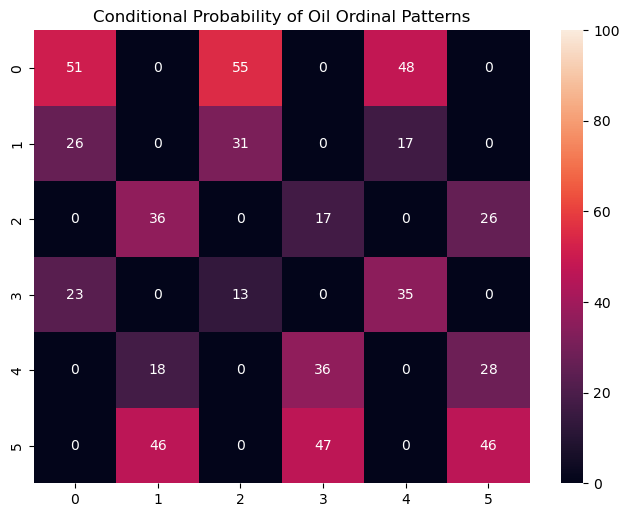

In [9]:
plt.figure(figsize=(8,6),dpi=100)
plt.title('Conditional Probability of Oil Ordinal Patterns')
sns.heatmap(datap,vmin=0,vmax=100,annot=True)
plt.show()

In [18]:
OIL=yf.Ticker('CL=F')
oil=OIL.history(start='2010-01-01', end='2015-01-01' ,interval='1d')
oil_close = oil['Close'].values

In [19]:
GOLD=yf.Ticker('gc=F')
gold=GOLD.history(start='2010-01-01', end='2015-01-01' ,interval='1d')
gold_close = gold['Close'].values

In [20]:
len(oil_close),len(gold_close)

(1258, 1258)

In [56]:
bins = 25
d = 3
gold_ln = localNormalization(gold_close,bins) 
oil_ln = localNormalization(oil_close,bins) 
oil_op = timeSeriesPattern(oil_ln, d)
gold_op = timeSeriesPattern(gold_ln, d)

In [58]:
mi = mutualEntropy(gold_op, oil_op,bins)
p_coeff,p_value = pearsonr(gold_op, oil_op)
print(f'Mutual Entropy: {mi} | Correlation Coefficent : {p_coeff} | P value : {p_value}')

Mutual Entropy: 0.05853320171088372 | Correlation Coefficent : 0.23843731620115968 | P value : 1.0745700136443117e-17


In [60]:
oil_close_r = oil['Close'].pct_change(1)
gold_close_r = gold['Close'].pct_change(1)

In [ ]:
bins = 25
gold_ln = localNormalization(gold_close,bins) 
oil_ln = localNormalization(oil_close,bins) 